In [ ]:
import pandas as pd

In [2]:
summaries = pd.read_csv("../Data/summaries.zip")

In [14]:
# Recall that....
# MovieID links the rows here to the rows of the Kaggle Dataset
# PlotFragments is a frament (either a third or a half) of the long wiki plot
# SummaryFragment is a randomly chosen sentence from a summary of the 
#       corresponding plot fragment
summaries

,MovieId,PlotFragments,SummaryFragment,summary_length
0,0,"A bartender is working at a saloon, serving dr...",bartender is working at a saloon serving drink...,11
1,0,"They assault the Irish man, pulling his hat ov...",the bartender then sprays seltzer water in Nat...,21
2,0,"A bartender is working at a saloon, serving dr...",carrie Nation and her followers burst inside .,8
3,1,"The moon, painted with a smiling face hangs ov...",the moon hangs over a park at night .,9
4,1,"The moon smiles. They embrace, and the moon's ...",the moon smiles.,3
...,...,...,...,...
100475,34884,The film centres around a young woman named Am...,"however, the two separate before they are able...",14
100476,34884,Although his ticket had a strict no-transfer p...,a BuzzFeed article about the story became viral .,9
100477,34884,This is too unrealistic!' And the project didn...,the project didn’t get any traction because ev...,14
100478,34884,The film centres around a young woman named Am...,"however, the two separate before they are able...",14


In [13]:
summaries['summary_length'] = summaries.apply(lambda row: len(row['SummaryFragment'].split()), 
                                              axis=1)

In [15]:
truncated_summaries = summaries.drop(summaries[summaries.summary_length < 6].index)

In [18]:
truncated_summaries['summary_length'].describe()

count    98992.000000
mean        15.348856
std          5.545676
min          6.000000
25%         12.000000
50%         14.000000
75%         18.000000
max         59.000000
Name: summary_length, dtype: float64

In [19]:
from sklearn.model_selection import train_test_split

summaries_train, summaries_test = train_test_split(truncated_summaries, test_size=0.25)

In [21]:
summaries_test

,MovieId,PlotFragments,SummaryFragment,summary_length
74135,25782,"It is also known that Prince Vijay, nephew of ...","the film now moves to Kiran's hotel, where ama...",18
51653,17655,"One Valentine's evening a group of single, dat...",Brett (Guy Pearce) is a science journalist for...,12
56522,19695,Charlie's friends won't tell him where Maggie ...,Charlie's friends won't tell him where Maggie ...,18
59231,20660,"Thomas Smithers (Postlethwaite), who has made ...",Thomas Smithers (Postlethwaite) hires the famo...,21
63111,22022,The plot revolves around the life of aspiring ...,plot revolves around the life of aspiring writ...,15
...,...,...,...,...
32944,11406,Bill's wishes end up causing more trouble due ...,bill's wishes end up causing more trouble due ...,12
19658,6930,Jesse (Robert Wagner) and Frank James (Jeffrey...,Jesse (Robert Wagner) and Frank James (Jeffrey...,16
88605,30788,"Aadhi feels that Dhana has changed a lot, so A...",aadhi attempts to send Dhana in jail for a mur...,16
73503,25561,Amateur boxer Ajay Mehra (Sunny Deol) is livin...,boxer is living with his brother and sister-in...,11


In [22]:
summaries_train.to_csv("../Data/summaries_train.csv", index=False, compression="zip")
summaries_test.to_csv("../Data/summaries_test.csv", index=False, compression="zip")

## Generating data to train cross-encoder

Generates a dataset which contains pairs of plot fragments/summarizing sentences, and a corresponding similarity score. The plot fragment & summary sentence similarity score is...
+ low if they are from different movies
+ medium if the sentence is from a summary of a different fragment of the same movie
+ high if the sentence is from a summary of that exact plot fragment

In [37]:
from random import random

num_samples = 20000
threshold = 0.4

same_summary_fragment = 0.8
same_movie = 0.6
different_movie = 0.2

cross_encoder_train = []

# generate num_samples many samples
for i in range(num_samples):
    sample1 = summaries_train.sample()
    if random() < threshold:
        # 40% are automatically chosen to be highly similar
        s1 = sample1.iloc[0]['PlotFragments']
        s2 = sample1.iloc[0]['SummaryFragment']
        score = same_summary_fragment
        cross_encoder_train.append([s1, s2, score])
    else:
        # otherwise, the second movie & fragment is chosen at random
        # (and thus will mostly be totally different from 1st choice)
        sample2 = summaries_train.sample()
        s1 = sample1.iloc[0]['PlotFragments']
        s2 = sample2.iloc[0]['SummaryFragment']
        s1_prime = sample2.iloc[0]['PlotFragments']
        m1 = sample1.iloc[0]['MovieId']
        m2 = sample2.iloc[0]['MovieId']
        if s1 == s1_prime:
            score = same_summary_fragment
        elif m1 == m2:
            score = same_movie
        else:
            score = different_movie
        cross_encoder_train.append([s1, s2, score])

In [38]:
# turn our list into a dataframe
cross_encoder_train = pd.DataFrame(cross_encoder_train, 
                                   columns=['Sentence1', 'Sentence2', 'Score'])

<AxesSubplot:>

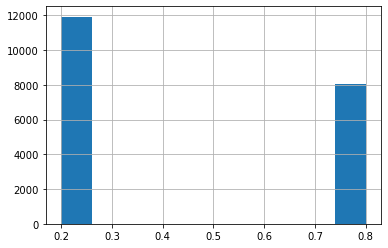

In [39]:
# Just as designed, ~ 40% are highly similar, and the huge majority
#     of the rest are highly different
cross_encoder_train['Score'].hist()

In [40]:
cross_encoder_train.to_csv("../Data/cross_encoder_train.csv", index=False, compression="zip")